# Literature overview



In [1]:
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd
from thefuzz import fuzz
import json
import time
import numpy as np
import umap.plot
import os
import umap.plot
import plotly.graph_objects as go
from plotly.offline import plot
from IPython.display import display, HTML
import base64 
import plotly.io as pio
import requests
from PIL import Image
import matplotlib.pyplot as plt

pio.renderers.default = "plotly_mimetype"

# REQUIRED CELL

DATA_ROOT = "../data/repro-mri-scoping/repro_mri_scoping"

np.seterr(divide = 'ignore') 

def get_by_id(paper_id):

    response = requests.post(
    'https://api.semanticscholar.org/graph/v1/paper/batch',
    params={'fields': 'abstract,tldr,year,embedding'},
    json={"ids": [paper_id]})
    
    if response.status_code == 200:
        return response
    else:
        return None

def get_id(title):
    """
    Query Semantic Scholar API by title.
    """
    api_url = "https://api.semanticscholar.org/graph/v1/paper/search"
    params = {"query": title}
    
    response = requests.get(api_url, params=params)
    
    if response.status_code == 200:
        result = response.json()
        print(result['total'])
        for re in result['data']:
            print(re)
            if fuzz.ratio(re['title'],title) > 90:
                return re['paperId']
            else:
                return None
    else:
        return None

def bulk_search(query,save_json):
    """
    The returns 1000 results per query. If the total number of 
    hits is larger, the request should be iterated using tokens.
    """
    query = "(code | data | open-source | github | jupyter ) + (('MRI' + 'brain') | (MRI + 'neuroimaging')) + reproducib~"
    fields = "abstract"
    url = f"http://api.semanticscholar.org/graph/v1/paper/search/bulk?query={query}&fields={fields}"
    r = requests.get(url).json()
    print(f"Found {r['total']} documents")
    retrieved = 0
    
    with open(save_json, "a") as file:
        while True:
            if "data" in r:
                retrieved += len(r["data"])
                print(f"Retrieved {retrieved} papers...")
                for paper in r["data"]:
                    print(json.dumps(paper), file=file)
            if "token" not in r:
                break
            r = requests.get(f"{url}&token={r['token']}").json()
    print(f"Retrieved {retrieved} papers. DONE")

def read_json_file(file_name):
    with open(file_name, 'r') as json_file:
        json_list = list(json_file)
    return json_list

def write_json_file(file_name, dict_content):
    with open(file_name, 'w') as json_file:
        json_file.write(json.dumps(dict_content))
    
def get_output_dir(file_name):
    op_dir = "../output"
    if not os.path.exists(op_dir):
        os.mkdir(op_dir)
    return os.path.join(op_dir,file_name)

def flatten_dict(input):
    result_dict = {}
    # Iterate over the list of dictionaries
    for cur_dict in input:
        # Iterate over key-value pairs in each dictionary
        for key, value in cur_dict.items():
            # If the key is not in the result dictionary, create a new list
            if key not in result_dict:
                result_dict[key] = []
            # Append the value to the list for the current key
            result_dict[key].append(value)
    return result_dict
    

/Users/agah/opt/anaconda3/envs/py310/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
2024-12-18 11:58:40.651928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/agah/opt/anaconda3/envs/py310/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same sign

In [ ]:
#OPTIONAL CELL

literature_records = get_output_dir("literature_records.json")
search_terms = "(code | data | open-source | github | jupyter ) + (('MRI' + 'brain') | (MRI + 'neuroimaging')) + reproducib~"

# This will save output/literature_records.json

bulk_search(search_terms,literature_records)

## Add articles associated with the reproducibility insights

Among 1098 articles included in the these Semantic Scholar records, SPECTER vector embeddings [@Cohan2020-tw] were available for 612 articles, representing the publicly accessible content in abstracts and titles. The high-dimensional semantic information captured by the word embeddings was visualized using the uniform manifold approximation and projection method [@McInnes2018-sc].

````{admonition} Crawling content

To include the paper IDs of the articles highlighted by reproducibility insights, we will utilize filenames from the `repro_mri_scoping/repro_insights_parsed_nov23` directory. For more information about this dataset, please refer to the following details.

In order to reduce crawler activity on the target website, spider commands are not included in the notebook. Instead, the content obtained by using the crawler (November 2023) was provided as part of the dataset (`repro_mri_scoping/repro_insights_parsed_nov23`). 

You can run the following commands **in a terminal** to re-run the crawler:   

```
cd crawler  
scrapy crawl mrmh
```

This will save the outputs in `crawler/crawler_outputs` directory. Files are named according to the captured URLs. To expand or narrow down the search interval, please modify the following block in `crawler/insights/spiders/mrmh.py`:

```python
                 for year in range(0, 4)  # assuming 2023
                 for month in range(1, 13)
                 for day in range(1, 32)]
```

After the crawling process is completed, the details of the article upon which the interview is based will be retrieved from the Semantic Scholar API. Following this, `title`, `abstract`, and `TLDR` (if availabe) sections will be prepended to each document. To perform these tasks on the crawled content, please run the following in terminal: 

```
python parse_crawled_content.py
```

Parsed outputs will be saved to `crawler/crawler_output/collection`, filenames will attain `paperId` (the uniqe ID assigned by Semantic Scholar). 

```{note}
Some of the content fetched from the web needs minor edits. Please see `crawler/insights/spiders/NOTES.txt`. 
```
````

In [2]:
# REQUIRED CELL

# To load THE ORIGINAL LIST, please comment in the following
lit_list = read_json_file(os.path.join(DATA_ROOT,"literature_records.json"))

# Read the LATEST literature records returned by the above search
# Note that this may include new results (i.e., new articles) 

#literature_records = get_output_dir("literature_records.json")
#lit_list = read_json_file(literature_records)

# Collect all the paper IDs from the literature search
lit_ids = [json.loads(entry)['paperId'] for entry in lit_list]

# Get all paper ids for the articles linked to 
insights_path = os.path.join(DATA_ROOT,"repro_insights_parsed_nov23")
insights_ids = [f.split(".")[0] for f in os.listdir(insights_path) if f.endswith('.txt')]

# Combine all IDs (unique)
paper_ids_all = list(set(lit_ids + insights_ids))
print(f"Total: {len(paper_ids_all)} papers ")

Total: 1098 papers 



```{admonition} Note
The following cell is commented out as it involves a series of API calls that takes some time to complete. 
```

In [ ]:
# OPTIONAL CELL 

# slices = [(0, 499), (499, 998), (998, None)]
# request_fields = 'title,venue,year,embedding,citationCount'

# results = []
# for start, end in slices:
#     print(len(paper_ids_all[start:end]))
#     re = requests.post(
#             'https://api.semanticscholar.org/graph/v1/paper/batch',
#             params={'fields': request_fields},
#             json={"ids": paper_ids_all[start:end]})
#     if re.status_code == 200:
#         print(f"Got results {start}:{end} interval")
#         results.append(re.json())
#         time.sleep(15) # Rate limiting.
#     else:
#         print(f"WARNING slice {start}:{end} did not return results: {re.text}")

# ALTERNATIVE 
# The above API call should work fast as the requests are sent in batch. 
# However, it frequently throws 429 error. If that's the case, following will 
# also work, but takes much longer and a few articles may not be captured.

# results = []
# for cur_id in paper_ids_all:
#     #print(len(paper_ids_all[start:end]))
#     re = requests.get(
#             f'https://api.semanticscholar.org/graph/v1/paper/{cur_id}',
#             params={'fields': request_fields})
#     if re.status_code == 200:
#         results.append(re.json())
#     else:
#         print(f"WARNING request for {cur_id} could not return results: {re.text}")

# # Write outputs
# write_json_file(get_output_dir("literature_data.json"),results)

```{admonition} Gathering Articles with Embeddings

While utilizing the Semantic Scholar API, it's important to note that not all returned article details include word embeddings generated by [SPECTER](https://github.com/allenai/scidocs) (v1) based on the title and abstract. Currently, we are filtering out articles where embeddings are available, totaling 612 out of 1098. Future efforts may focus on addressing missing data by running the SPECTER model on articles without embeddings.
```

In [3]:
# REQUIRED CELL

# Load the ORIGINAL data
lit_data = json.loads(read_json_file(os.path.join(DATA_ROOT,"literature_data.json"))[0])

# If you'd like to read from the output directory (LATEST)
#lit_data = json.loads(read_json_file(get_output_dir("literature_data.json"))[0])

papers_data = []

for res in lit_data:
    if 'embedding' in res.keys():
        if res['embedding']:
            cur_rec = {"embedding":res['embedding']['vector'],
                       "title":res['title'],
                       "venue": res['venue'],
                       "year": res['year'],
                       "is_mrmh": "Other",
                       "paperId": res['paperId'],
                       "n_citation": res['citationCount']}
            if res['paperId'] in insights_ids:
                cur_rec['is_mrmh'] = "Highlights"
    
            papers_data.append(cur_rec)

papers_data_dict = papers_data
# From a list of dicts to a dict of lists.
papers_data = flatten_dict(papers_data)


```{admonition} Dimension reduction and visualization

To visualize the semantic relationship between the captured articles (a 612x768 matrix), we are going to use Uniform Manifold Approximation and Projection (UMAP) method. 
```

In [4]:
# REQUIRED CELL

# Reduce to 2D feature
umap_model_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2,random_state=42)
umap_2d = umap_model_2d.fit_transform(np.array(papers_data['embedding']))
umap_2d_mapper = umap_model_2d.fit(np.array(papers_data['embedding']))

# Reduce to 3D feature
umap_model_3d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3,random_state=42)
umap_3d = umap_model_3d.fit_transform(np.array(papers_data['embedding']))

/Users/agah/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/agah/opt/anaconda3/envs/py310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/agah/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/agah/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/agah/opt/anaconda3/envs/py310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:


```{admonition}
Create the connectivity plot to be used as a background image for the interactive data visualization.
```

In [ ]:
# OPTIONAL CELL

ax = umap.plot.connectivity(umap_2d_mapper, edge_bundling='hammer')

# To save with opt size
# width_in_inches = 1200/300
# aspect_ratio = ax.figure.get_size_inches()[1] / ax.figure.get_size_inches()[0]
# height_in_inches = width_in_inches * aspect_ratio
# ax.figure.set_size_inches(width_in_inches, height_in_inches)

ax.set_title("")
ax.axis('off') 
ax.figure.savefig("umap_bg_new.png", dpi=300, bbox_inches='tight',edgecolor=None)
plt.close(ax.figure)

The MRI systems cluster was predominantly composed of articles published in MRM, with only two publications appearing in a different journal {cite:p}`Adebimpe2022-zp,Tilea2009-zu`. Additionally, this cluster was sufficiently distinct from the rest of the reproducibility literature, as can be seen by the location of the dark red dots on Fig. 1.

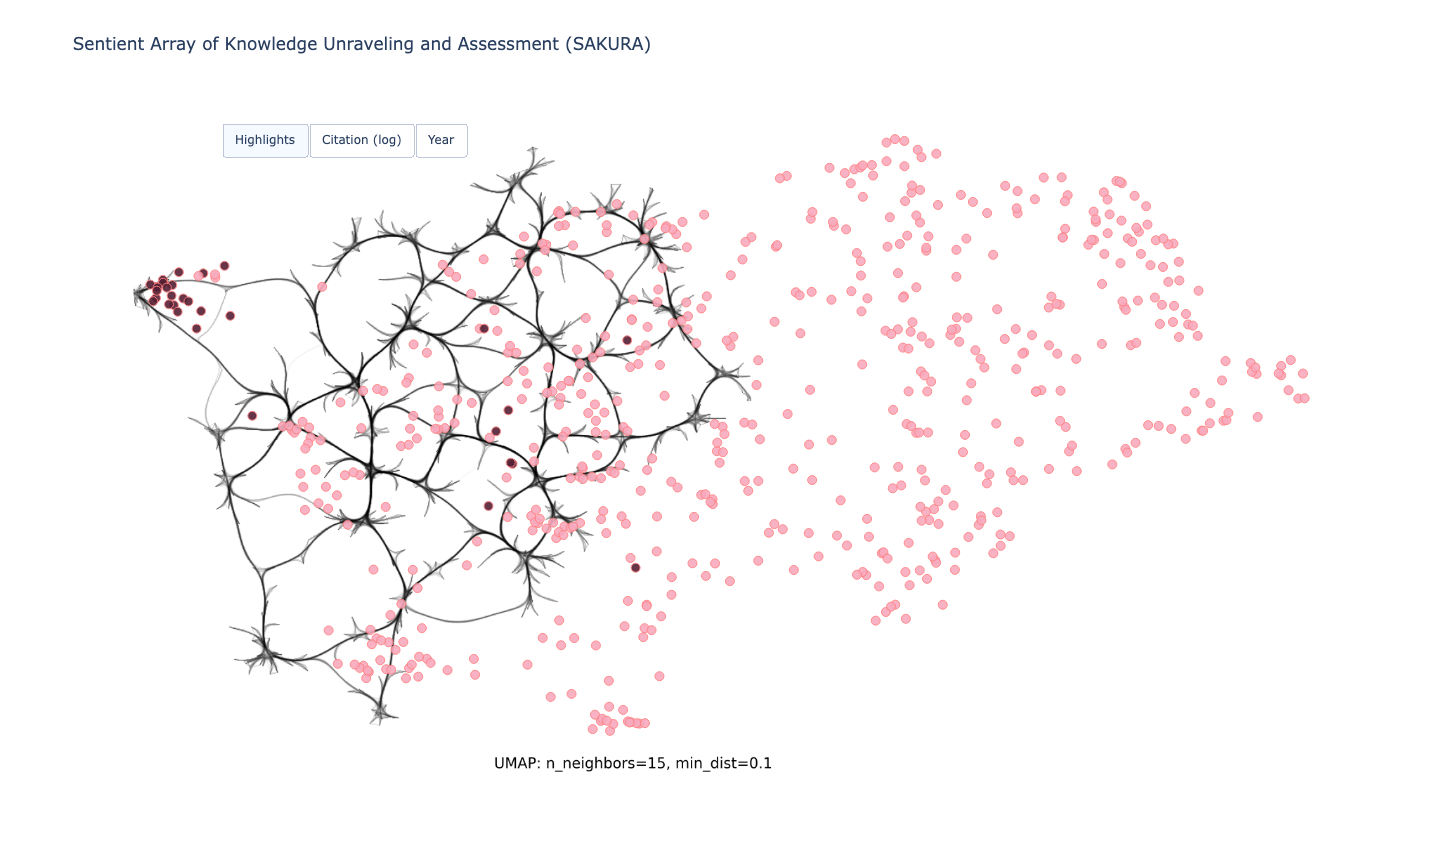

In [5]:
#| label: fig1-cell

# Create Plotly figure
fig = go.Figure()

# Scatter plot for UMAP in 2D
scatter_2d = go.Scatter(
    x=umap_2d[:, 0],
    y=umap_2d[:, 1],
    mode='markers',
    marker = dict(color =["#562135" if item == 'Highlights' else "#f8aabe" for item in papers_data['is_mrmh']],
                                          size=9, 
                                          line= dict(color="#ff8080",width=1),
                                          opacity=0.9),
    customdata= [f"<b>{dat['title']}</b> <br>{dat['venue']} <br>Cited by: {dat['n_citation']} <br>{dat['year']}" for dat in papers_data_dict],
    hovertemplate='%{customdata}',
    visible = True,
    name='2D'
)
fig.add_trace(scatter_2d)

# Add dropdown
fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"showscale":True,"marker": dict(color =["#562135" if item == 'Highlights' else "#f8aabe" for item in papers_data['is_mrmh']],
                                          size=9, 
                                          line= dict(color="#ff8080",width=1),
                                          opacity=0.9)}],
                    label="Highlights",
                    method="restyle"
                ),
                dict(
                    args=[{"marker": dict(color = np.log(papers_data['n_citation']),colorscale='Plotly3',size=9, colorbar=dict(thickness=10,title = "Citation (log)",orientation="h",len=0.5))}],
                    label="Citation (log)",
                    method="restyle"
                ),
                dict(
                    args=[{"marker": dict(color = papers_data['year'],colorscale='Viridis',size=9,colorbar=dict(thickness=10, orientation="h", len=0.5, title="Year"))}],
                    label="Year",
                    method="restyle"
                )
            ]),
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.11,
            xanchor="left",
            y=0.98,
            yanchor="top"
        ),
    ]
)

plotly_logo = base64.b64encode(open(os.path.join('umap_bg.png'), 'rb').read())

# with Image.open(os.path.join('umap_bg.png')) as img:
#     bg_width, bg_height = img.size


fig.update_layout(
    images=[dict(
        source='data:image/png;base64,{}'.format(plotly_logo.decode()),
        xref="paper", 
        yref="paper",
        x=0.03,  # Start from the left edge
        y=0.978,  # Start from the top edge
        sizex=1,  # Stretch to full width
        sizey=1,  # Stretch to full height
        xanchor="left",
        yanchor="top",
        layer="below"
    )]
)


fig.update_layout(yaxis={'visible': False, 'showticklabels': False})
fig.update_layout(xaxis={'visible': False, 'showticklabels': False})

fig.update_layout(
    title='Sentient Array of Knowledge Unraveling and Assessment (SAKURA)',
    hovermode='closest',
    autosize=True,
    width=850,
    height=850,
    paper_bgcolor = "white",
    plot_bgcolor = "white"
)


fig.show()

**Figure-1:** Edge-bundled connectivity of the 612 articles identified by the literature search. A notable cluster (red) is formed by the MRM articles that were featured in the reproducible research insights (purple nodes), particularly in the development of MRI methods. Notable clusters for other studies (pink) are annotated by gray circles.

In [ ]:
#| label: fig13d-cell

fig = go.Figure()

# Scatter plot for UMAP in 3D
scatter_3d = go.Scatter3d(
    x=umap_3d[:, 0],
    y=umap_3d[:, 1],
    z=umap_3d[:, 2],
    mode='markers',
    marker = dict(color =["#562135" if item == 'Highlights' else "#f8aabe" for item in papers_data['is_mrmh']],
                                      size=9, 
                                      line= dict(color="#ff8080",width=1),
                                      opacity=0.9),
    customdata= [f"<b>{dat['title']}</b> <br>{dat['venue']} <br>Cited by: {dat['n_citation']} <br>{dat['year']}" for dat in papers_data_dict],
    hovertemplate='%{customdata}',
    visible = True,
    name='3D'
)

fig.add_trace(scatter_3d)

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"marker": dict(color =["#562135" if item == 'Highlights' else "#f8aabe" for item in papers_data['is_mrmh']],
                                          size=9,
                                          line= dict(color="#ff8080",width=1),
                                          opacity=0.9)}],
                    label="Highlights",
                    method="restyle"
                ),
                dict(
                    args=[{"marker": dict(color = np.log(papers_data['n_citation']),colorscale='Plotly3',size=9,colorbar=dict(thickness=10,orientation="h", len=0.5,title="Citation (log)"))}],
                    label="Citation (log)",
                    method="restyle"
                ),
                dict(
                    args=[{"marker": dict(color = papers_data['year'],colorscale='Viridis',size=9,colorbar=dict(thickness=10, len=0.5, orientation="h", title="Year"))}],
                    label="Year",
                    method="restyle"
                )
            ]),
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.11,
            xanchor="left",
            y=0.98,
            yanchor="top"
        ),
    ]
)



# Update layout
fig.update_layout(title='UMAP 3D',
                 height = 900,
                 width = 900,
                 hovermode='closest',
                 template='plotly_dark')


fig.show()

```{bibliography}
```